In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
PrPV = 0.95 # The probability of testing positive as vampire (true positive)
PrPM = 0.01 # The probability of testing positive as mortal (false positive)
PrV = 0.001 # The probability of being a vampire

# To compute if someone is a vampire conditional on them testing positive...
# Pr(vampire|positive) = ( Pr(positive|vampire) * Pr(vampire) ) / Pr(positive)

# A positive test result is the sum of a true positive * known vampire probability with false positive * known mortal probability
PrP = PrPV * PrV + PrPM * (1 - PrV)

PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

In [4]:
def posterior_grid_approximation(successes, trials, prob_points):
    grid = np.linspace(0,1,prob_points)
    prior = np.repeat(0.5, prob_points)
    likelihood = stats.binom.pmf(successes, trials, grid)
    posterior = likelihood * prior
    posterior = posterior / posterior.sum()
    return grid, posterior

## plotting samples

In [36]:
grid_a, posterior_a = posterior_grid_approximation(6,9,1000)
samples = np.random.choice(grid_a, p=posterior_a, size=int(1e4), replace=True)

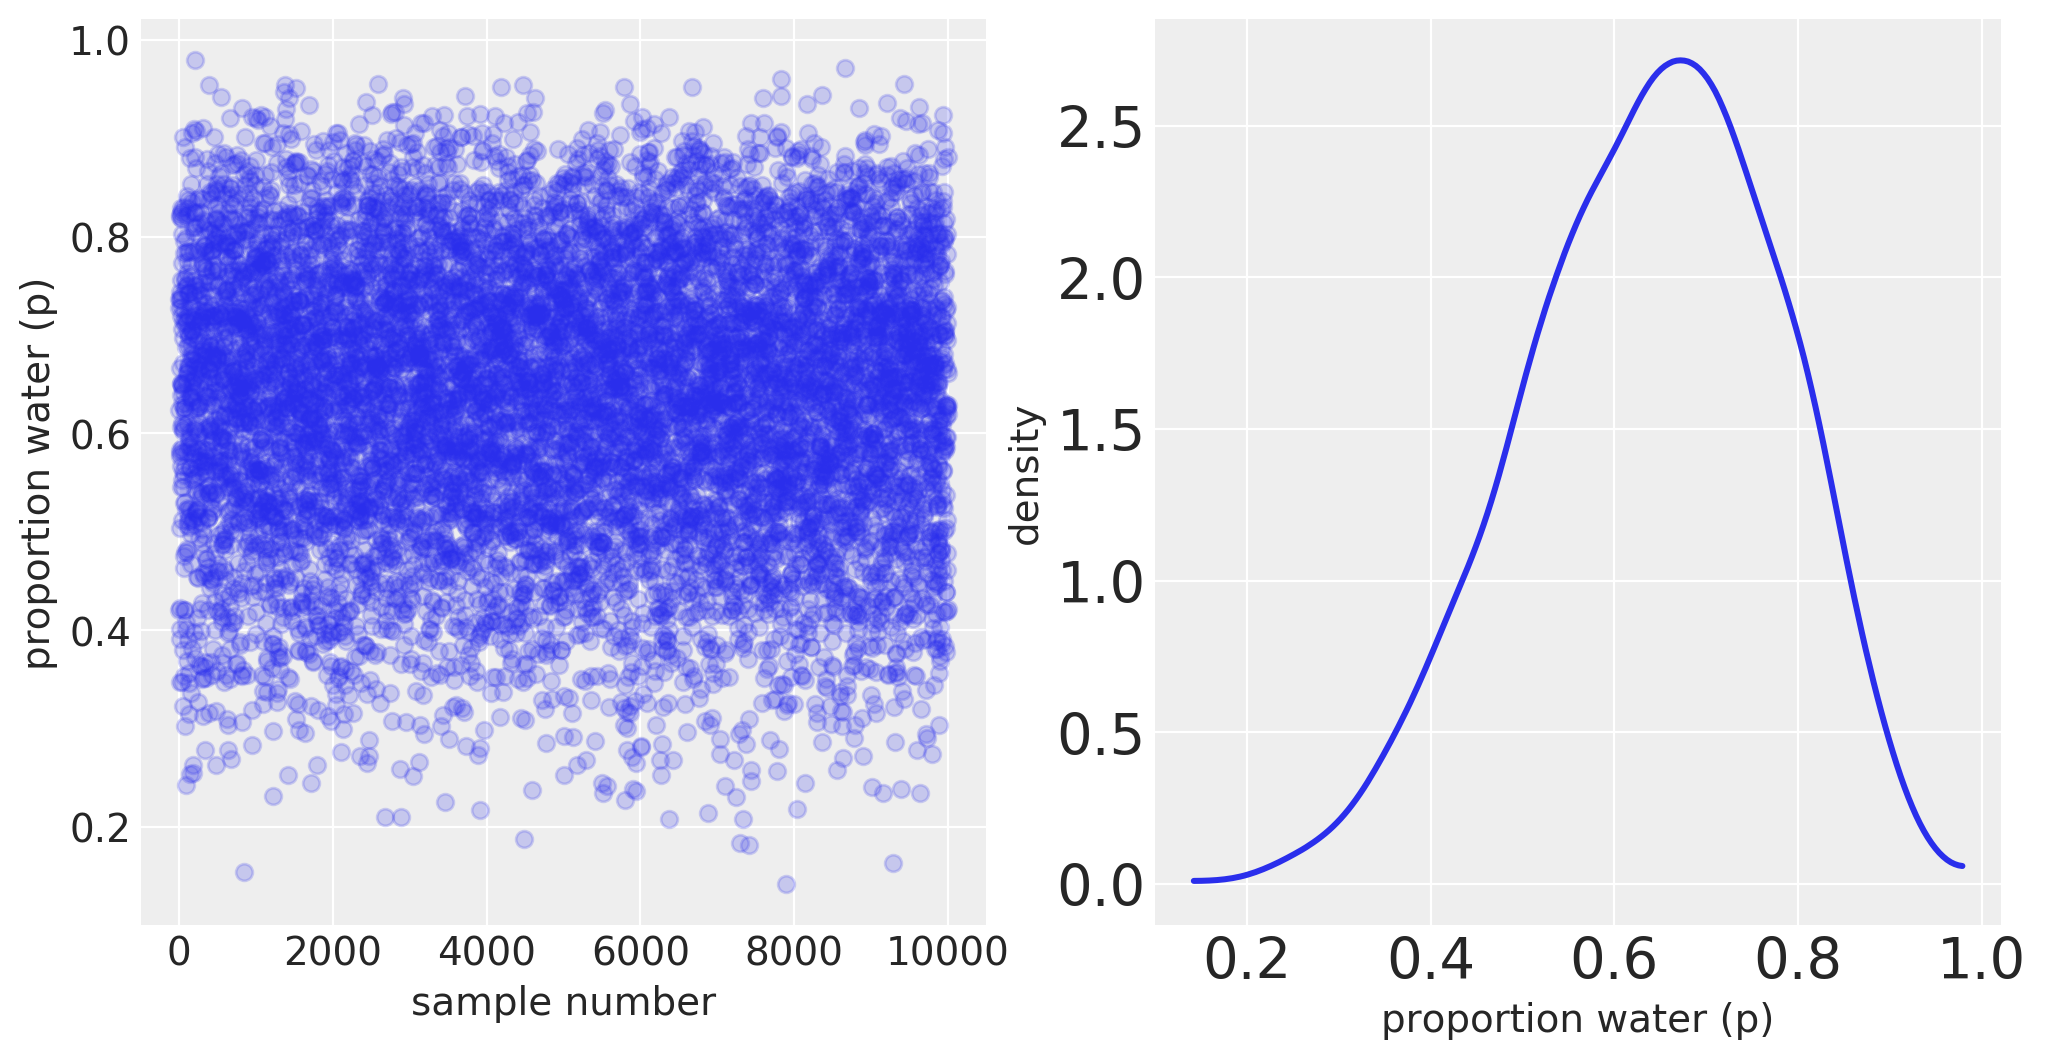

In [37]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.plot(samples, 'o', alpha=0.2)
ax0.set_xlabel('sample number', fontsize=14)
ax0.set_ylabel('proportion water (p)', fontsize=14)
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel('proportion water (p)', fontsize=14)
ax1.set_ylabel('density', fontsize=14);

## summarizing samples

In [38]:
# posterior probability of water being less than 0.5...
sum(posterior_a[grid_a < 0.5])

0.17187458902022876

In [39]:
# posterior probability of water being less than 0.5 **through samples**
# sum of samples divided by count of samples to get frequency
sum(samples < 0.5) / 1e4

0.1662

In [40]:
# sampling posterior between two values
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6088

## probability intervals

In [41]:
# 80th percentile of posterior probabilities (from 0)
np.percentile(samples, 80)

0.7617617617617618

In [42]:
# 80th percentile of posterior probabilities (from 10 - 90)
np.percentile(samples, [10, 90])

array([0.45045045, 0.81181181])

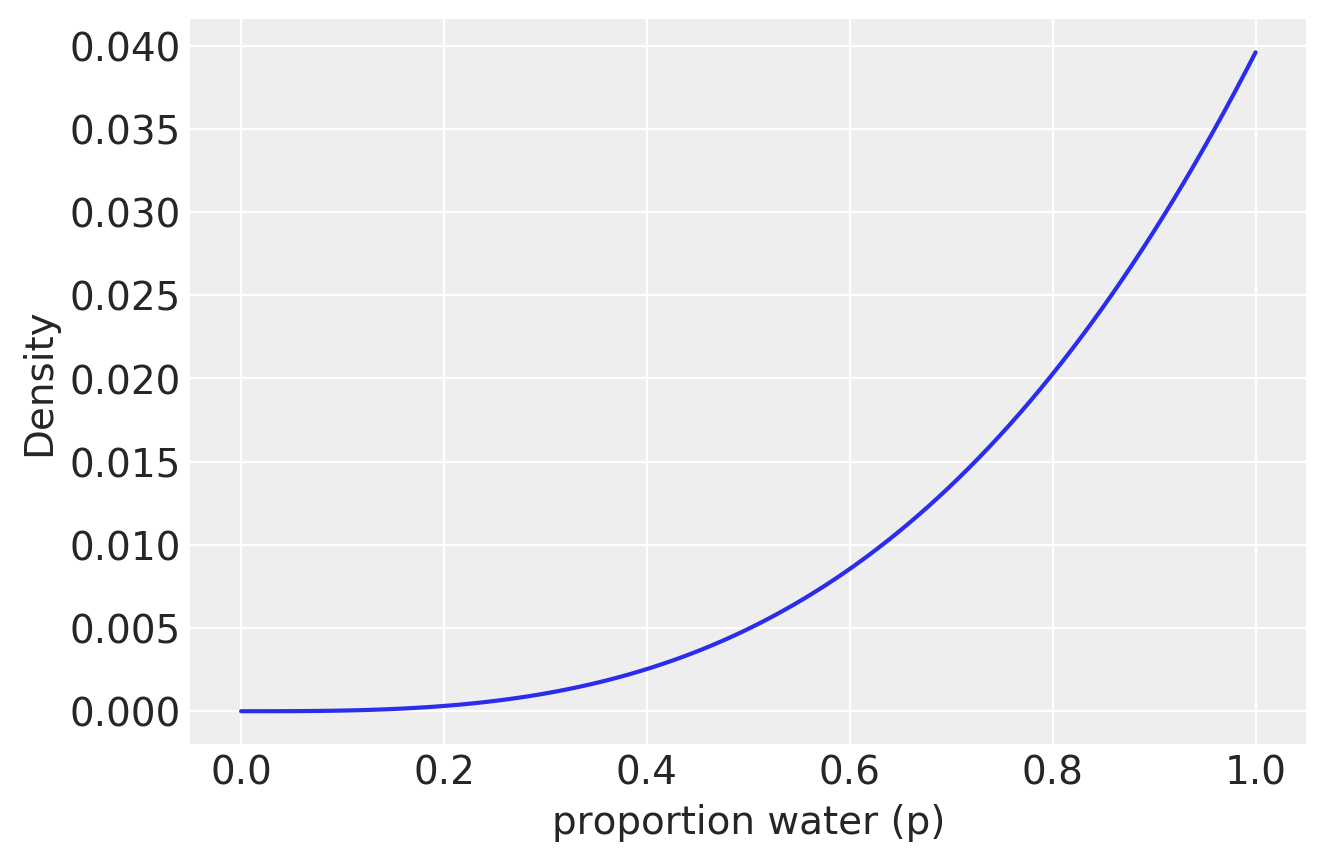

In [43]:
# a skewed distribution, where the maximum is at the boundary...
grid_b, posterior_b = posterior_grid_approximation(3, 3, 100)
plt.plot(grid_b, posterior_b)
plt.xlabel('proportion water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14);

In [44]:
# the following percentile interval (middle 50%) is misleading (it does not include the peak)
samples2 = np.random.choice(grid_b, p=posterior_b, size=int(1e4), replace=True)
np.percentile(samples2, [25, 75])

array([0.70707071, 0.93939394])

**highest posterior density interval**

In [45]:
az.hpd(samples2, credible_interval=0.5)

array([0.84848485, 1.        ])

## computing MAP

In [47]:
grid_a[posterior_a == max(posterior_a)]

array([0.66666667])

In [48]:
grid_b[posterior_b == max(posterior_b)]

array([1.])

**via samples from posterior**

In [49]:
stats.mode(samples)[0]

array([0.67167167])

In [50]:
stats.mode(samples2)[0]

array([1.])

## computing mean and median of samples

In [51]:
np.mean(samples)

0.637619019019019

In [52]:
np.median(samples)

0.6466466466466466

In [53]:
np.mean(samples2)

0.8048828282828283

In [54]:
np.median(samples2)

0.8484848484848485

## loss functions and point estimates

In [55]:
# calculating expected loss when decision value implies a loss that proportional to distance from true value
# e.g. if decision = 0.5
sum(posterior_a * abs(0.5 - grid_a))

0.16406263699495904

In [56]:
sum(posterior_b * abs(0.5 - grid_b))

0.31626874808693

**find the parameter value that minimizes the expected loss**

In [60]:
# best point estimate turns out to be median
loss = [sum(posterior_a * abs(p - grid_a)) for p in grid_a]
grid_a[loss == min(loss)]

array([0.64464464])

In [61]:
loss2 = [sum(posterior_b * abs(p - grid_b)) for p in grid_b]
grid_b[loss2 == min(loss2)]

array([0.84848485])

## dummy data

In [62]:
# calculated likelihood for a range of values (0, 1, and 2) where probability is 70% and observation count is 2
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

In [63]:
# simulating a dummy observation from the calculated likelihood...
stats.binom.rvs(n=2, p=0.7, size=1)

array([2])

In [64]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 1, 2, 2, 1, 2, 1, 2, 1, 2])

In [65]:
stats.binom.rvs(n=2, p=0.7, size=100)

array([2, 2, 0, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 0, 2, 2, 1, 2, 1, 0,
       1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 0, 2])

In [66]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.08894, 0.42207, 0.48899]

Text(0, 0.5, 'Frequency')

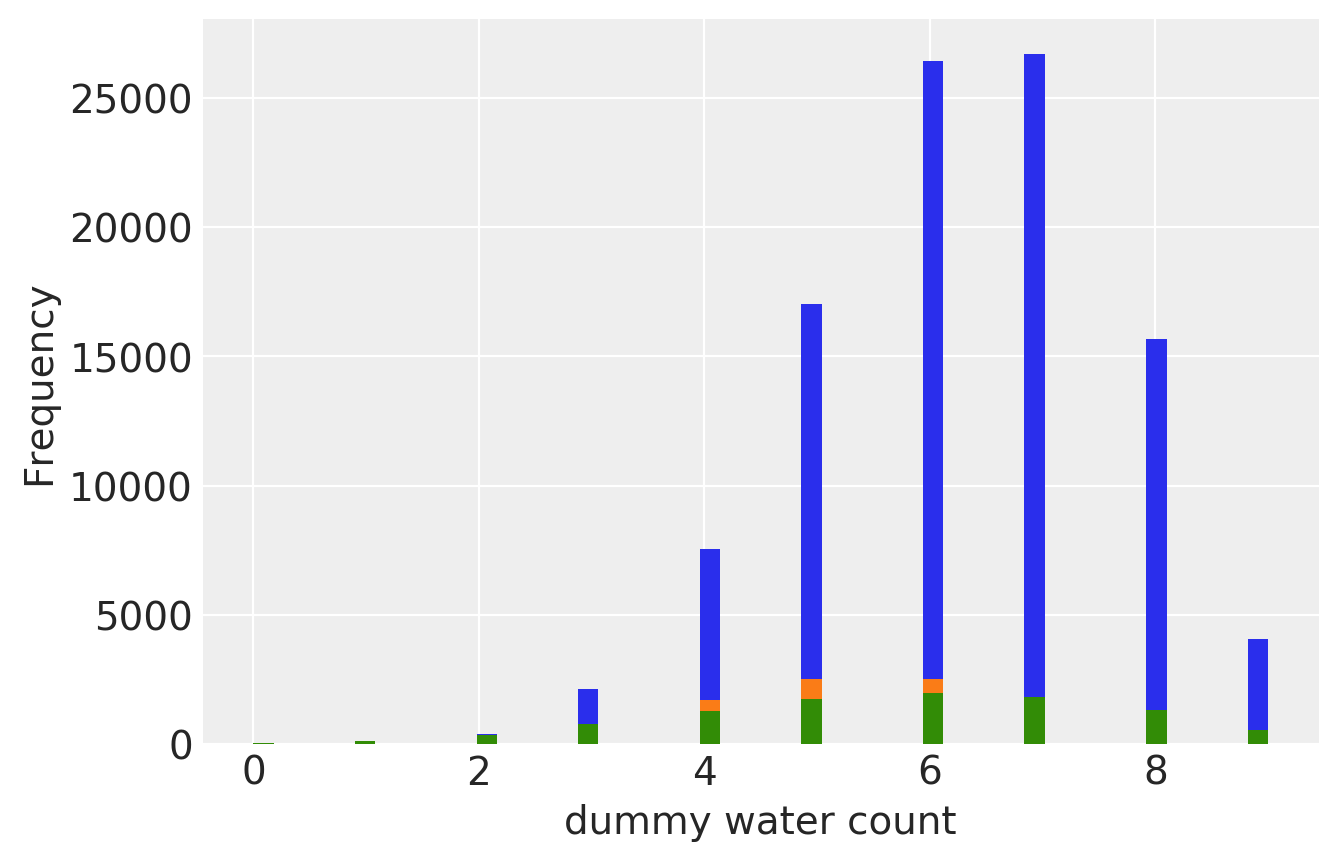

In [73]:
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
dummy_w2 = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
dummy_w3 = stats.binom.rvs(n=9, p=samples)
plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.hist(dummy_w2, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.hist(dummy_w3, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)